# Studying Sensitivies

In [1]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,normalize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import IPython
import ast
from scipy.stats import norm

import joblib
%load_ext autoreload
%autoreload 2
%aimport IS_misc_functions
from IS_misc_functions import *
from misc_functions import *
from actuarial_training import *
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

import json

#import warnings
#warnings.filterwarnings("ignore")

Load the models

In [2]:
model_actuarial_0999 = keras.models.load_model("model_actuarial_0999.h5", compile=False)
model_actuarial_0999.compile(loss='mse')
scaler_actuarial = joblib.load('scaler_actuarial.gz')

C:\Users\julia\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Consider a baseline Portfolio

In [3]:
with open("probs.txt") as tweetfile:
    probs = json.load(tweetfile)
probs = {float(k):float(v) for k,v in probs.items()}
PDs =  np.maximum(np.array([float(k) for k,v in probs.items()])/100,1e-10)
PD_distribution = np.array([float(v) for k,v in probs.items()])

In [4]:
B = 1 # Batch Size


# Bounds for the parameters
ELGD_bounds = 0,0.6
EAD_bounds = 0,1
PD_bounds = 0,0.52
omega_bounds = 0,1
obligor_bounds = 99.9,100
max_obligors = 100 

In [5]:
# Fix the randomness
#np.random.seed(seed=36)
#np.random.seed(seed=7)
#np.random.seed(seed=15)
#np.random.seed(seed=26)
#np.random.seed(seed=9)
#np.random.seed(seed=215)
#np.random.seed(seed=282)
np.random.seed(seed=251)

# Sample some parameters
LGD_Vector,EAD_Vector,PD_Vector,rho_Vector = create_sample_actuarial(ELGD_bounds,EAD_bounds,PD_bounds,omega_bounds,obligor_bounds,B,
                                                   PDs = PDs,PD_distribution=PD_distribution,PDs_Sample = True)
LGD_Vector1 = np.zeros((1,100))
LGD_Vector2 = np.zeros((1,100))
LGD_Vector1[LGD_Vector>0] = 0.1
LGD_Vector2[LGD_Vector>0] = 0.45

Cap the PDs

In [6]:
PD_Vector = np.minimum(PD_Vector,sorted(PDs)[-3])
#PD_Vector[rho_Vector>0] = sorted(PDs)[-5]
#rho_Vector[rho_Vector>0]=0.5

Change Number of Obligors

In [7]:
GA_01 = []
GA_01_approx  = []
GA_045 = []
GA_045_approx  = []
for number in np.arange(10,101,2):
    N = np.zeros((1,max_obligors))
    N[0,:] = np.pad(np.repeat(1,number),(0,max_obligors-number)) # Number of Obligors    
    LGD_Vector_new_01 = LGD_Vector1*N
    LGD_Vector_new_045 = LGD_Vector2*N
    EAD_Vector_new  = EAD_Vector*N
    PD_Vector_new  = PD_Vector*N
    rho_Vector_new  = rho_Vector*N
    EAD_Vector_new   = EAD_Vector_new /np.repeat(np.sum(EAD_Vector_new ,1)[:,np.newaxis],max_obligors,axis = 1)
    
    GA_approx_01 = GA_GL(PD_Vector_new[LGD_Vector_new_01>0],
                               LGD_Vector_new_01[LGD_Vector_new_01>0],
                               EAD_Vector_new[LGD_Vector_new_01>0], 1, # Vector of Maturities
      q = 0.999, # quantile level
      xi = 0.25, # precision parameter,
      nu = 0.25,# recovery parameter
      rho = rho_Vector_new[LGD_Vector_new_01>0],
      LGD_constant = False,
          minimize_rho_distance = True)
    GA_approx_045 = GA_GL(PD_Vector_new[LGD_Vector_new_045>0],
                               LGD_Vector_new_045[LGD_Vector_new_045>0],
                               EAD_Vector_new[LGD_Vector_new_045>0], 1, # Vector of Maturities
      q = 0.999, # quantile level
      xi = 0.25, # precision parameter,
      nu = 0.25,# recovery parameter
      rho = rho_Vector_new[LGD_Vector_new_045>0],
      LGD_constant = False,
          minimize_rho_distance = True)
    
    Input_01 = np.concatenate([LGD_Vector_new_01 ,EAD_Vector_new ,PD_Vector_new ,rho_Vector_new,
                            np.reshape(GA_approx_01,(1,1))],axis =1)
    Input_045 = np.concatenate([LGD_Vector_new_045 ,EAD_Vector_new ,PD_Vector_new ,rho_Vector_new,
                            np.reshape(GA_approx_045,(1,1))],axis =1)
    GA_actuarial_new_01  = model_actuarial_0999.predict(scaler_actuarial.transform(Input_01), verbose=0)
    GA_01.append(GA_actuarial_new_01)
    GA_01_approx.append(GA_approx_01)
    GA_actuarial_new_045  = model_actuarial_0999.predict(scaler_actuarial.transform(Input_045), verbose=0)
    GA_045.append(GA_actuarial_new_045)
    GA_045_approx.append(GA_approx_045)

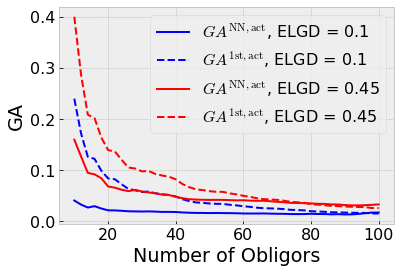

In [9]:
plt.plot(np.arange(10,101,2),[GA_01[i][0][0] for i in range(len(GA_01))],label = r"$GA^{\rm NN,act}$, ELGD = 0.1",color = "blue")
plt.plot(np.arange(10,101,2),GA_01_approx,label = r"$GA^{\rm 1st,act}$, ELGD = 0.1",linestyle = "dashed",color = "blue")
plt.plot(np.arange(10,101,2),[GA_045[i][0][0] for i in range(len(GA_045))],label = r"$GA^{\rm NN,act}$, ELGD = 0.45",color = "red")
plt.plot(np.arange(10,101,2),GA_045_approx,label = r"$GA^{\rm 1st,act}$, ELGD = 0.45",linestyle = "dashed",color = "red")
plt.xlabel("Number of Obligors")
plt.ylabel("GA")
plt.legend(loc="upper right")
plt.savefig('Plots/actuarial_sensitivity_obligors_0999.pdf', format='pdf',bbox_inches='tight')
plt.show()

Reduce to a smaller number of obligors (50 obligors)

In [9]:
reduced_obligors = 50
N = np.zeros((1,max_obligors))
N[0,:] = np.pad(np.repeat(1,reduced_obligors),(0,max_obligors-reduced_obligors)) # Number of Obligors 
LGD_Vector,EAD_Vector,PD_Vector,rho_Vector = LGD_Vector*N,EAD_Vector*N/np.sum(EAD_Vector*N),PD_Vector*N,rho_Vector*N
LGD_Vector1 = np.zeros((1,100))
LGD_Vector2 = np.zeros((1,100))
LGD_Vector1[LGD_Vector>0] = 0.1
LGD_Vector2[LGD_Vector>0] = 0.45

### Visualization of the portfolio

In [10]:
# Sort by EAD
tup = [(e,p) for (e,p) in zip(EAD_Vector[EAD_Vector>0],PD_Vector[EAD_Vector>0])]
tup.sort(key = lambda x: x[0]) 
EAD_Sorted = [e for (e,p) in tup]
PD_Sorted = [p for (e,p) in tup]
df =pd.DataFrame(tup)
df.columns = ["EAD","PD"]

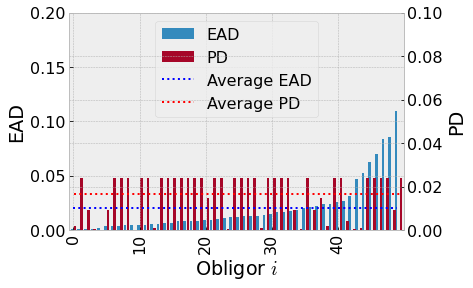

In [31]:
ax = df.plot(kind="bar",width = 0.8)
ax2 = ax.twinx()
for r in ax.patches[len(df):]:
    r.set_transform(ax2.transData)
ax.plot([np.mean(EAD_Vector[LGD_Vector>0])]*50,color = "blue",linestyle = "dotted",label = "Average EAD")
ax2.plot([np.mean(PD_Vector[LGD_Vector>0])]*50,color = "red",linestyle = "dotted",label = "Average PD")
ax2.set_ylim(0, 0.1)
ax.set_ylim(0, 0.2)
ax.set_xticks([0,10,20,30,40,50])
ax.set_ylabel('EAD')
ax2.set_ylabel('PD')
ax.set_xlabel("Obligor $i$")
# Combining legends
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
ax.legend([handles[i] for i in [1,2,0,3]],
          [labels[i] for i in [1,2,0,3]],loc = "upper center") # Rearrange Order
plt.savefig('Plots/actuarial_sensitivity_Portfolio.pdf', format='pdf',bbox_inches='tight')
plt.show()

### Compute Gradients

In [16]:
indices = np.argsort(EAD_Vector)
GA_approx_01 = GA_GL(PD_Vector[LGD_Vector>0],
                           LGD_Vector2[LGD_Vector>0],
                           EAD_Vector[LGD_Vector>0], 1, # Vector of Maturities
  q = 0.999, # quantile level
  xi = 0.25, # precision parameter,
  nu = 0.25,# recovery parameter
  rho = rho_Vector[LGD_Vector>0],
  LGD_constant = False)
inp = tf.concat([LGD_Vector2,
                      EAD_Vector,
                      PD_Vector,
                      rho_Vector,
                            np.reshape(GA_approx_01,(1,1))],axis =1) 
mod_inp = inp_mod = tf.cast(scaler_actuarial.transform(inp), tf.float32)
with tf.GradientTape() as tape:
    tape.watch(mod_inp)    
    preds = model_actuarial_0999(mod_inp)
grads = tape.gradient(preds, mod_inp)
PD_grads = [grads[0,200+i] for i  in indices[0][50:]]
EAD_grads = [grads[0,100+i] for i  in indices[0][50:]]

C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


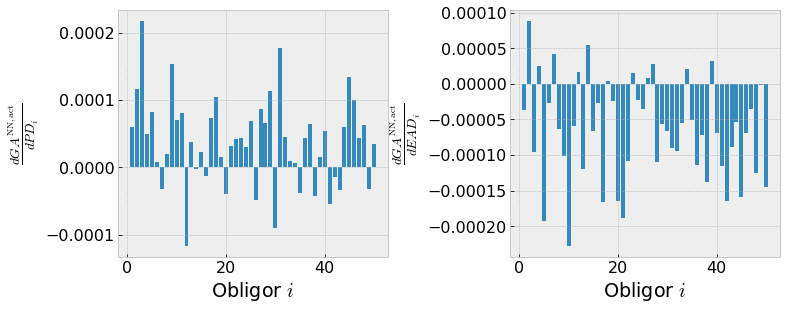

In [17]:
figure, axis = plt.subplots(1, 2,figsize=(12, 6)) 
figure.tight_layout(pad=5.0)
axis[0].bar(range(1,51),PD_grads)
axis[0].set_ylabel(r"$\frac{d GA^{\rm NN,act}}{d PD_i}$", rotation= 90)
axis[0].set_xlabel("Obligor $i$")

axis[1].bar(range(1,51),EAD_grads)
axis[1].set_ylabel(r"$\frac{d GA^{\rm NN,act}}{d EAD_i}$", rotation= 90)
axis[1].set_xlabel("Obligor $i$")
plt.savefig('Plots/actuarial_sensitivity_gradients.pdf', format='pdf',bbox_inches='tight')
plt.show()

Change PD to next large rating class

In [18]:
PD_01_change_NN = []
PD_01_change_approx = []
# Compute base GA
GA_approx_01 = GA_GL(PD_Vector[LGD_Vector>0],
                           LGD_Vector2[LGD_Vector>0],
                           EAD_Vector[LGD_Vector>0], 1, # Vector of Maturities
  q = 0.999, # quantile level
  xi = 0.25, # precision parameter,
  nu = 0.25,# recovery parameter
  rho = rho_Vector[LGD_Vector>0],
  LGD_constant = False)
inp = tf.concat([LGD_Vector2,
                      EAD_Vector,
                      PD_Vector,
                      rho_Vector,
                            np.reshape(GA_approx_01,(1,1))],axis =1) 
base_GA = model_actuarial_0999(scaler_actuarial.transform(inp))
for i in range(50):
    # Increase PD of obligor i by 0.01
    PD_Vector_mod = np.copy(PD_Vector)
    rank = sorted(PDs).index(PD_Vector_mod[0][i])
    PD_Vector_mod[0][i] = sorted(PDs)[rank+1]
    PD_Vector_mod = tf.convert_to_tensor(PD_Vector_mod)
    # COmptue new GA
    GA_approx_02 = GA_GL(PD_Vector_mod[LGD_Vector>0],
                               LGD_Vector2[LGD_Vector>0],
                               EAD_Vector[LGD_Vector>0], 1, # Vector of Maturities
      q = 0.999, # quantile level
      xi = 0.25, # precision parameter,
      nu = 0.25,# recovery parameter
      rho = rho_Vector[LGD_Vector>0],
      LGD_constant = False)
    inp = tf.concat([LGD_Vector2,
                          EAD_Vector,
                          PD_Vector_mod,
                          rho_Vector,
                                np.reshape(GA_approx_02,(1,1))],axis =1) 
    # Compute difference
    PD_01_change_NN.append((model_actuarial_0999(scaler_actuarial.transform(inp))-base_GA)[0][0].numpy())
    PD_01_change_approx.append(GA_approx_02-GA_approx_01)

C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as me

C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_c

C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as me

In [19]:
PD_01_change_NN = [PD_01_change_NN[i] for i  in indices[0][50:]]
PD_01_change_approx = [PD_01_change_approx[i] for i  in indices[0][50:]]

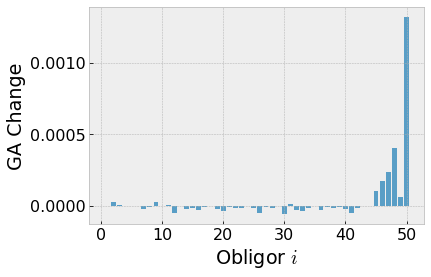

In [28]:
plt.bar(range(1,51),PD_01_change_NN,alpha = 0.8,label = r"$GA^{\rm NN,act}_{(i)} -GA^{\rm NN,act} $")
#plt.bar(range(1,51),np.array(PD_01_change_approx)*0.03,color="red",alpha = 0.2,label = r"$GA^{\rm 1st,act}_{(i)} -GA^{\rm 1st,act} $")
plt.ylabel("GA Change", rotation= 90)
plt.xlabel("Obligor $i$")
plt.savefig('Plots/actuarial_sensitivity_PD_Change.pdf', format='pdf',bbox_inches='tight')
#plt.legend()
plt.show()

In [21]:
EAD_01_change = []
EAD_01_change_approx = []
# Compute base GA
GA_approx_01 = GA_GL(PD_Vector[LGD_Vector>0],
                           LGD_Vector2[LGD_Vector>0],
                           EAD_Vector[LGD_Vector>0], 1, # Vector of Maturities
  q = 0.999, # quantile level
  xi = 0.25, # precision parameter,
  nu = 0.25,# recovery parameter
  rho = rho_Vector[LGD_Vector>0],
  LGD_constant = False)
inp = tf.concat([LGD_Vector2,
                      EAD_Vector,
                      PD_Vector,
                      rho_Vector,
                            np.reshape(GA_approx_01,(1,1))],axis =1) 
base_GA = model_actuarial_0999(scaler_actuarial.transform(inp))
for i in range(50):
    # Increase EAD of obligor i
    EAD_Vector_mod = np.copy(EAD_Vector)
    EAD_Vector_mod[0][i]+= 0.01
    EAD_Vector_mod = tf.convert_to_tensor(EAD_Vector_mod)
    EAD_Vector_mod = EAD_Vector_mod/tf.reduce_sum(EAD_Vector_mod)
    # COmptue new GA
    GA_approx_02 = GA_GL(PD_Vector[LGD_Vector>0],
                               LGD_Vector2[LGD_Vector>0],
                               EAD_Vector_mod[LGD_Vector>0], 1, # Vector of Maturities
      q = 0.999, # quantile level
      xi = 0.25, # precision parameter,
      nu = 0.25,# recovery parameter
      rho = rho_Vector[LGD_Vector>0],
      LGD_constant = False)
    inp = tf.concat([LGD_Vector2,
                          EAD_Vector_mod,
                          PD_Vector,
                          rho_Vector,
                                np.reshape(GA_approx_02,(1,1))],axis =1) 
    # Compute difference
    EAD_01_change.append((model_actuarial_0999(scaler_actuarial.transform(inp))-base_GA)[0][0].numpy())
    EAD_01_change_approx.append(GA_approx_02-GA_approx_01)

C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as me

C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as me

C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_c

In [22]:
EAD_01_change = [EAD_01_change[i] for i  in indices[0][50:]]
EAD_01_change_approx = [EAD_01_change_approx[i] for i  in indices[0][50:]]

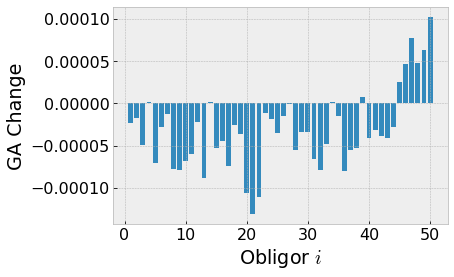

In [32]:
plt.bar(range(1,51),EAD_01_change,label = r"$GA^{\rm NN,act}_{(i)} -GA^{\rm NN,act} $")
#plt.bar(range(1,51),np.array(EAD_01_change_approx)*0.03,color = "red",alpha = 0.2)
plt.ylabel("GA Change", rotation= 90)
plt.xlabel("Obligor $i$")
#plt.legend()
plt.savefig('Plots/actuarial_sensitivity_EAD_Change.pdf', format='pdf',bbox_inches='tight')
plt.show()

Change PD

In [24]:
GA_01 = []
GA_01_approx  = []
GA_045 = []
GA_045_approx  = []

for PD_factor in np.arange(0.5,2,0.1):
    # Define Inputs
    LGD_Vector_new_01 = LGD_Vector1
    LGD_Vector_new_045 = LGD_Vector2
    EAD_Vector_new  = EAD_Vector
    PD_Vector_new  = np.minimum(PD_Vector*PD_factor,1)
    rho_Vector_new  = rho_Vector
    EAD_Vector_new   = EAD_Vector_new /np.repeat(np.sum(EAD_Vector_new ,1)[:,np.newaxis],max_obligors,axis = 1)
    
    
    GA_approx_01 = GA_GL(PD_Vector_new[LGD_Vector_new_01>0],
                               LGD_Vector_new_01[LGD_Vector_new_01>0],
                               EAD_Vector_new[LGD_Vector_new_01>0], 1, # Vector of Maturities
      q = 0.999, # quantile level
      xi = 0.25, # precision parameter,
      nu = 0.25,# recovery parameter
      rho = rho_Vector_new[LGD_Vector_new_01>0],
      LGD_constant = False,
      minimize_rho_distance = True)
    GA_approx_045 = GA_GL(PD_Vector_new[LGD_Vector_new_045>0],
                               LGD_Vector_new_045[LGD_Vector_new_045>0],
                               EAD_Vector_new[LGD_Vector_new_045>0], 1, # Vector of Maturities
      q = 0.999, # quantile level
      xi = 0.25, # precision parameter,
      nu = 0.25,# recovery parameter
      rho = rho_Vector_new[LGD_Vector_new_045>0],
      LGD_constant = False,
      minimize_rho_distance = True)    
    
    Input_01 = np.concatenate([LGD_Vector_new_01 ,EAD_Vector_new ,PD_Vector_new ,rho_Vector_new,
                            np.reshape(GA_approx_01,(1,1))],axis =1)
    Input_045 = np.concatenate([LGD_Vector_new_045 ,EAD_Vector_new ,PD_Vector_new ,rho_Vector_new,
                            np.reshape(GA_approx_045,(1,1))],axis =1)
    GA_actuarial_new_01  = model_actuarial_0999.predict(scaler_actuarial.transform(Input_01), verbose=0)
    GA_01.append(GA_actuarial_new_01)
    GA_01_approx.append(GA_approx_01)
    GA_actuarial_new_045  = model_actuarial_0999.predict(scaler_actuarial.transform(Input_045), verbose=0)
    GA_045.append(GA_actuarial_new_045)
    GA_045_approx.append(GA_approx_045)

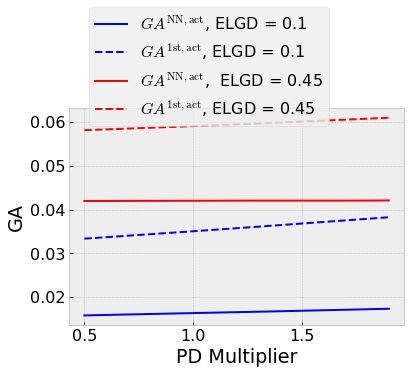

In [25]:
plt.plot(np.arange(0.5,2,0.1),[GA_01[i][0][0] for i in range(len(GA_01))],label = r"$GA^{\rm NN,act}$, ELGD = 0.1",color = "blue")
plt.plot(np.arange(0.5,2,0.1),GA_01_approx,label = r"$GA^{\rm 1st,act}$, ELGD = 0.1",linestyle = "dashed",color = "blue")
plt.plot(np.arange(0.5,2,0.1),[GA_045[i][0][0] for i in range(len(GA_045))],label = r"$GA^{\rm NN,act}$,  ELGD = 0.45",color = "red")
plt.plot(np.arange(0.5,2,0.1),GA_045_approx,label = r"$GA^{\rm 1st,act}$, ELGD = 0.45",linestyle = "dashed",color = "red")
plt.xlabel("PD Multiplier")
plt.ylabel("GA")
plt.legend(loc="upper right", bbox_to_anchor=(0.8, 1.5))
plt.savefig('Plots/actuarial_sensitivity_PD_0999.pdf', format='pdf',bbox_inches='tight')
plt.show()

Change Omega

In [26]:
GA_01 = []
GA_01_approx  = []
GA_045 = []
GA_045_approx  = []

for Omega_factor in np.arange(0.5,2,0.1):
    # Define Inputs
    LGD_Vector_new_01 = LGD_Vector1
    LGD_Vector_new_045 = LGD_Vector2
    EAD_Vector_new  = EAD_Vector
    PD_Vector_new  = PD_Vector
    rho_Vector_new  = np.minimum(rho_Vector*Omega_factor,1)
    EAD_Vector_new   = EAD_Vector_new /np.repeat(np.sum(EAD_Vector_new ,1)[:,np.newaxis],max_obligors,axis = 1)
    
    
    GA_approx_01 = GA_GL(PD_Vector_new[LGD_Vector_new_01>0],
                               LGD_Vector_new_01[LGD_Vector_new_01>0],
                               EAD_Vector_new[LGD_Vector_new_01>0], 1, # Vector of Maturities
      q = 0.999, # quantile level
      xi = 0.25, # precision parameter,
      nu = 0.25,# recovery parameter
      rho = rho_Vector_new[LGD_Vector_new_01>0],
      LGD_constant = False)
    GA_approx_045 = GA_GL(PD_Vector_new[LGD_Vector_new_045>0],
                               LGD_Vector_new_045[LGD_Vector_new_045>0],
                               EAD_Vector_new[LGD_Vector_new_045>0], 1, # Vector of Maturities
      q = 0.999, # quantile level
      xi = 0.25, # precision parameter,
      nu = 0.25,# recovery parameter
      rho = rho_Vector_new[LGD_Vector_new_045>0],
      LGD_constant = False)    
    
    Input_01 = np.concatenate([LGD_Vector_new_01 ,EAD_Vector_new ,PD_Vector_new ,rho_Vector_new,
                            np.reshape(GA_approx_01,(1,1))],axis =1)
    Input_045 = np.concatenate([LGD_Vector_new_045 ,EAD_Vector_new ,PD_Vector_new ,rho_Vector_new,
                            np.reshape(GA_approx_045,(1,1))],axis =1)
    GA_actuarial_new_01  = model_actuarial_0999.predict(scaler_actuarial.transform(Input_01), verbose=0)
    GA_01.append(GA_actuarial_new_01)
    GA_01_approx.append(GA_approx_01)
    GA_actuarial_new_045  = model_actuarial_0999.predict(scaler_actuarial.transform(Input_045), verbose=0)
    GA_045.append(GA_actuarial_new_045)
    GA_045_approx.append(GA_approx_045)

C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\julia\OneDrive - National University of Singapore\Projects\Capital Requirements of MDBs\Code_new\misc_functions.py:132: RuntimeWarning: invalid value encountered in sqrt
  K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)*(1/(1-1.5*b))*(1+(M-2.5)*b)
C:\Users\julia\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as me

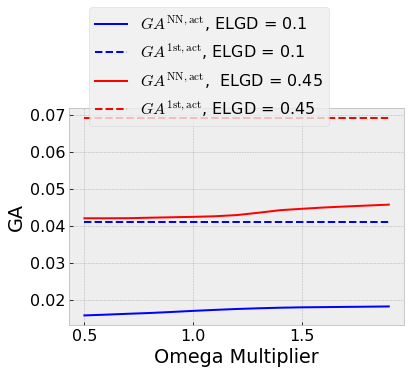

In [27]:
plt.plot(np.arange(0.5,2,0.1),[GA_01[i][0][0] for i in range(len(GA_01))],label = r"$GA^{\rm NN,act}$, ELGD = 0.1",color = "blue")
plt.plot(np.arange(0.5,2,0.1),GA_01_approx,label = r"$GA^{\rm 1st,act}$, ELGD = 0.1",linestyle = "dashed",color = "blue")
plt.plot(np.arange(0.5,2,0.1),[GA_045[i][0][0] for i in range(len(GA_045))],label = r"$GA^{\rm NN,act}$,  ELGD = 0.45",color = "red")
plt.plot(np.arange(0.5,2,0.1),GA_045_approx,label = r"$GA^{\rm 1st,act}$, ELGD = 0.45",linestyle = "dashed",color = "red")
plt.xlabel("Omega Multiplier")
plt.ylabel("GA")
plt.legend(loc="upper right", bbox_to_anchor=(0.8, 1.5))
plt.savefig('Plots/actuarial_sensitivity_omega_0999.pdf', format='pdf',bbox_inches='tight')
plt.show()